In [1]:
import json
import torch
import seaborn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
mat_dict = {}
path_lst = ['./results/ec_rnn+_model.pth', './results/ec_lstm+_model.pth', './results/ec_att_model.pth',
            './results/ec_base_model.pth', './results/ec_str_model.pth', './results/ec_geo_model.pth', 
            './results/ec_pre_model.pth', './results/ec+kt+mtl_model.pth', './results/ec+kt+e2e_model.pth']
key_list = ['rnn', 'lstm', 'att', 'base', 'str', 'geo', 'pre', 'mtl', 'e2e', ]
ttl_list = ['(a) RNN+', '(b) LSTM+', '(c) self-attention', '(d) EC base', '(e) EC+str', '(f) EC+geo', 
            '(g) EC+KT-pre', '(h) EC+KT+mtl', '(i) EC+KT+e2e', ]

In [3]:
for i, path in enumerate(path_lst):
    state = torch.load(path)
    try:
        mat = state['ec_net']['k_net.weight'].cpu().numpy()
    except KeyError:
        mat = state['net']['k_net.weight'].cpu().numpy()
    print("%s_matrix.shape" % key_list[i], mat.shape)
    mat_dict[key_list[i]] = mat.tolist()

rnn_matrix.shape (8, 128)
lstm_matrix.shape (8, 128)
att_matrix.shape (8, 50)
base_matrix.shape (8, 128)
str_matrix.shape (8, 128)
geo_matrix.shape (8, 128)
pre_matrix.shape (8, 128)
mtl_matrix.shape (8, 128)
e2e_matrix.shape (8, 128)


In [4]:
def pca_reduction(mat, dim=3):
    mat = mat - np.mean(mat, axis=0).reshape(1, -1)
    cov = np.matmul(mat.transpose(), mat) / mat.shape[1]
    egv, egm = np.linalg.eig(cov)
    dst = np.matmul(egm[:dim], mat.transpose())
    dst = np.matmul(dst.transpose(), egm[:dim, :dim])
    return dst

(8, 128)
(8, 128)
(8, 50)
(8, 128)
(8, 128)
(8, 128)


d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(8, 128)
(8, 128)
(8, 128)


d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\matplotlib\collections.py:546: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\matplotlib\colors.py:292: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


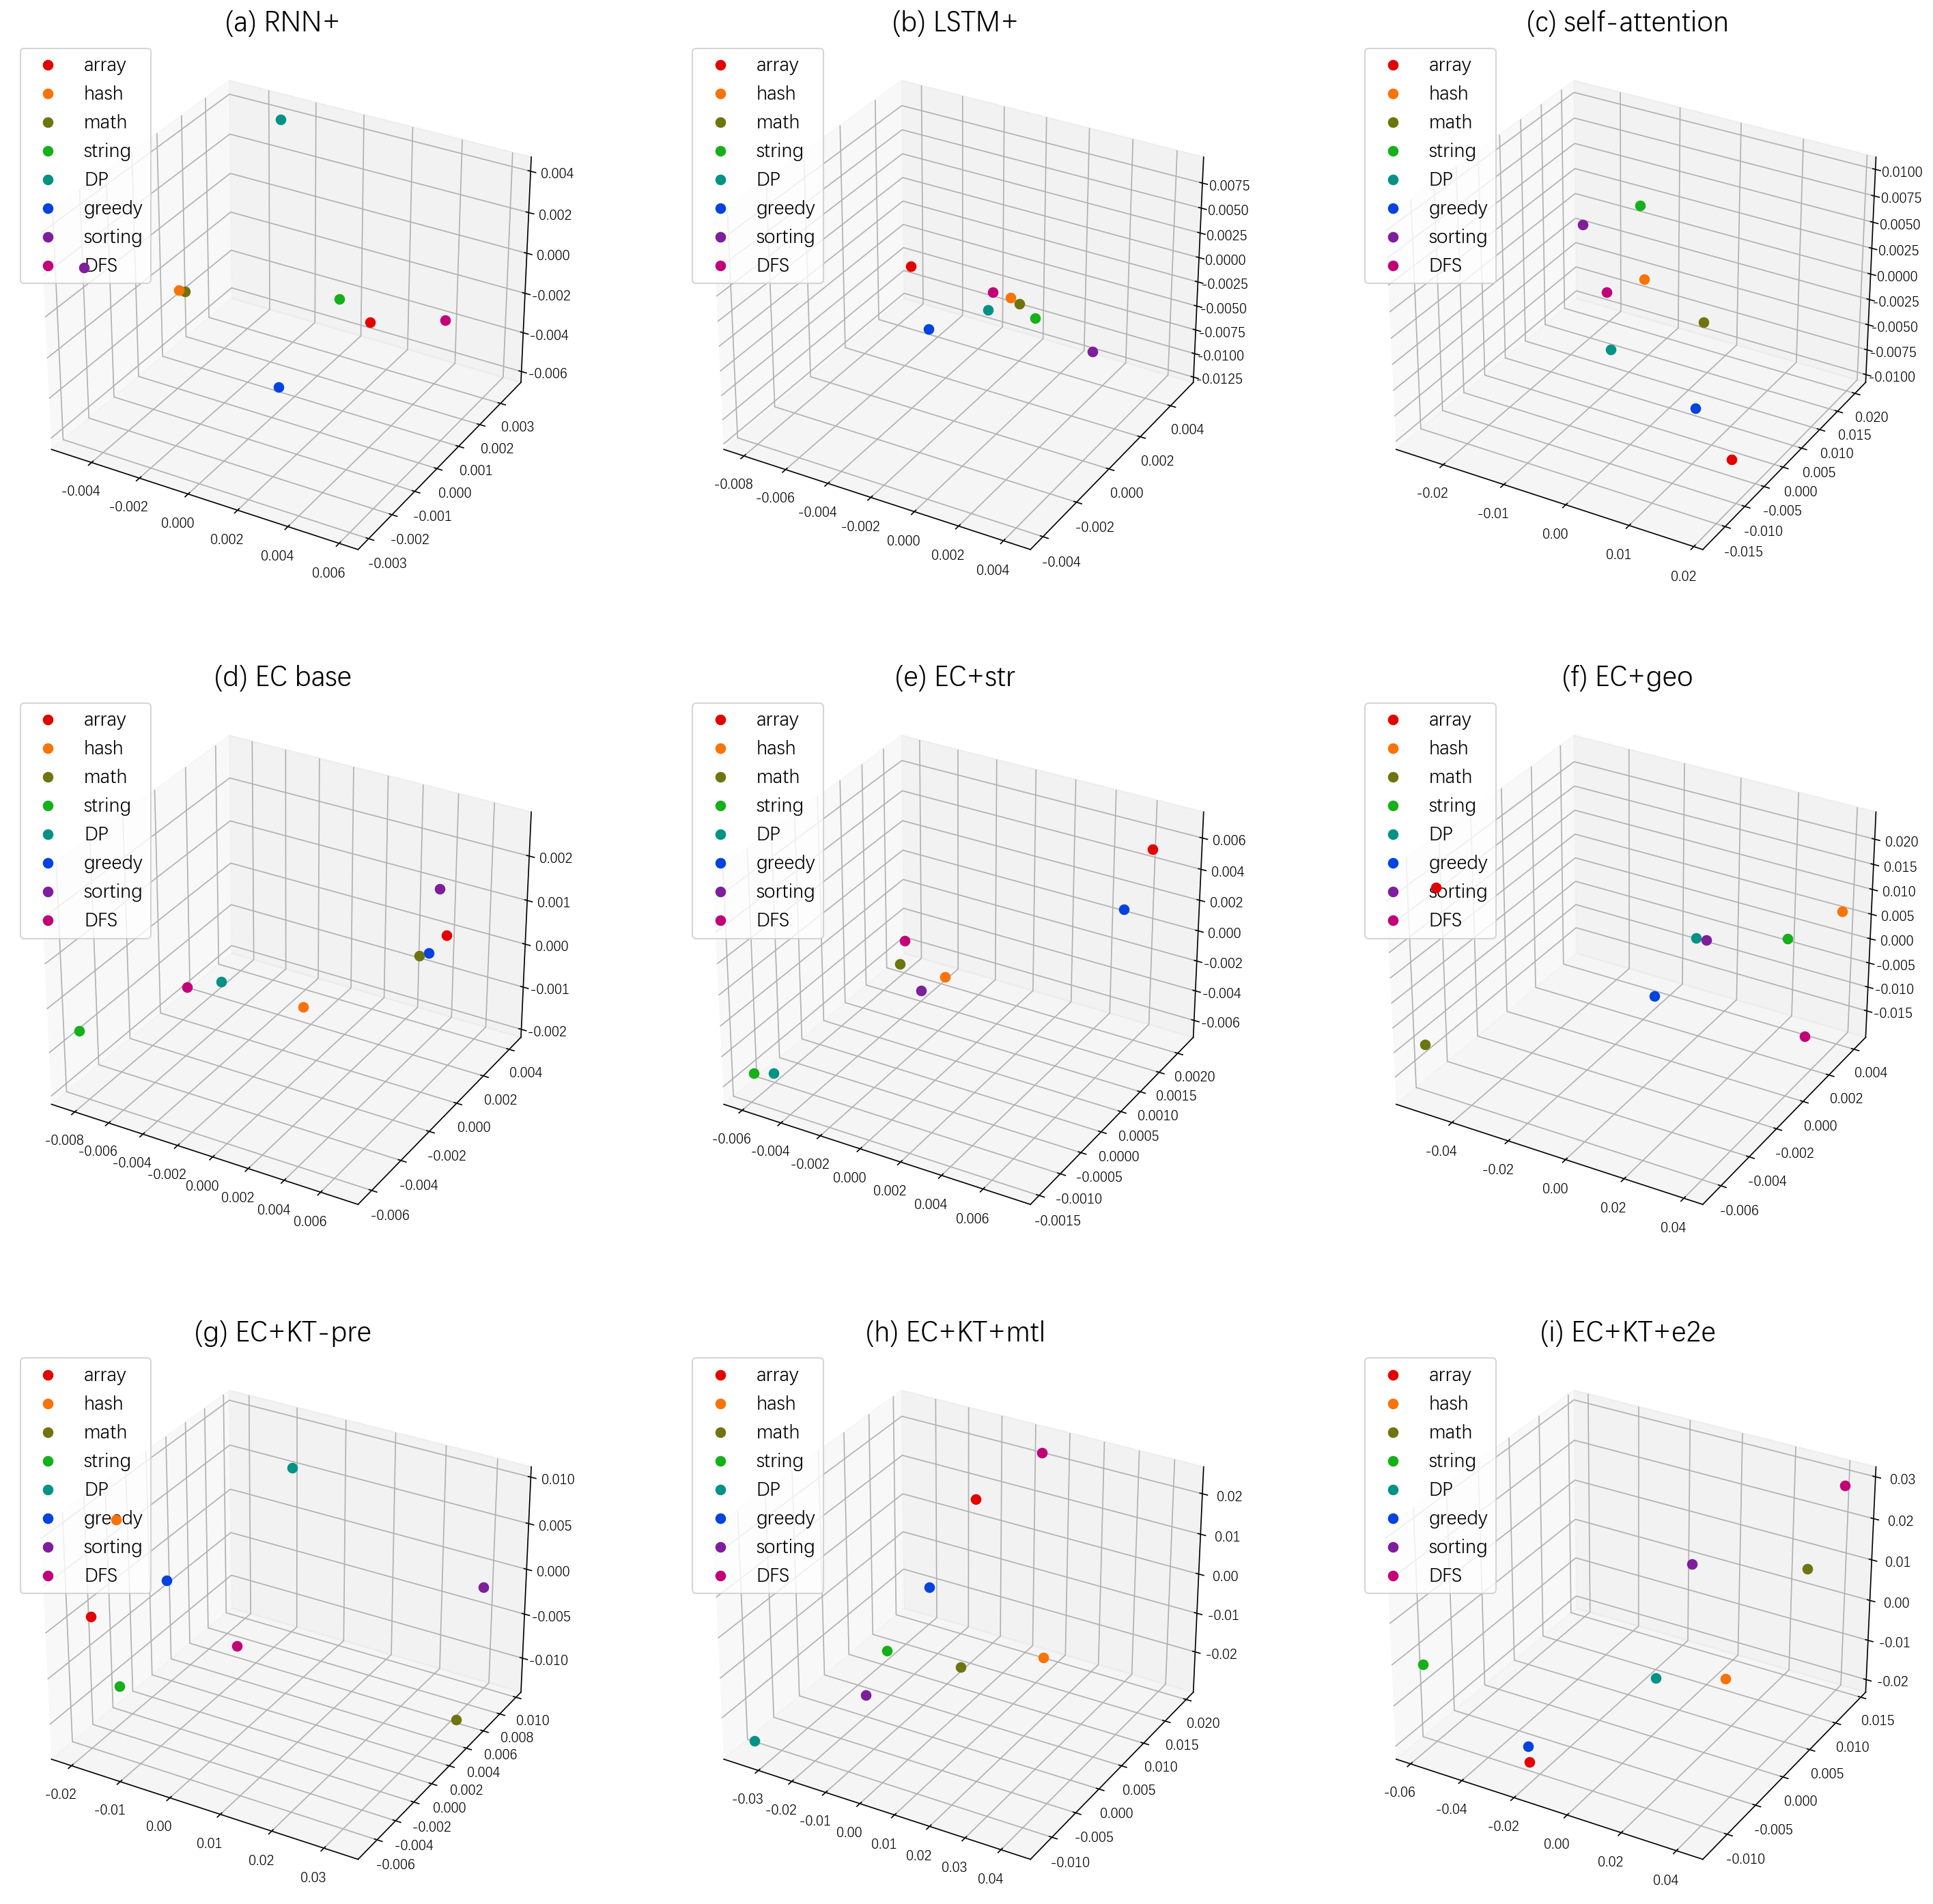

In [5]:
fig = plt.figure(num=1, figsize=(24, 24), dpi=150, clear=True)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)

axe_list = [fig.add_subplot(3, 3, i, projection='3d') for i in range(1, 10)]
lbl_list = ['array', 'hash', 'math', 'string', 'DP', 'greedy', 'sorting', 'DFS']
clr_list = ['red', 'orange', 'olive', 'green', 'teal', 'blue', 'purple', 'magenta']

mat_list = [np.array(mat_dict[key]) for key in key_list]

for i in range(9):
    print(mat_list[i].shape)
    dot_list = pca_reduction(mat_list[i], dim=3)
    for j in range(8):
        axe_list[i].scatter(dot_list[j, 0], dot_list[j, 1], dot_list[j, 2],
                            color=seaborn.xkcd_rgb[clr_list[j]], label=lbl_list[j], linewidths=3)
    axe_list[i].legend(loc='upper left', fontsize=14)
    axe_list[i].set_title(ttl_list[i], fontsize=20)

plt.savefig('./results/cmp_ec/cmp_ec_scatter.jpg')
plt.show()

In [6]:
def cos_reduction(mat):
    pro = np.matmul(mat, mat.transpose())
    nor = np.linalg.norm(mat, ord=2, axis=1)
    cos = pro / nor / nor.transpose()
    return cos

In [7]:
def coo_reduction(itm_lst, exe_lst=None):
    coo = np.array([[0] * 8] * 8)
    tot = np.array([0] * 8).reshape(-1, 1)
    exe_lst = [1] * 1500 if exe_lst is None else exe_lst
    for idx, itm in enumerate(itm_lst):
        cls = np.array(itm['class']).reshape(-1, 1)
        tot += cls * exe_lst[idx]
        cls = np.matmul(cls, cls.transpose())
        coo += cls * exe_lst[idx]
    coo = coo.tolist()
    tot = tot.reshape(-1).tolist()
    for idx in range(8):
        for jdx in range(8):
            coo[idx][jdx] /= tot[idx]
    return np.array(coo)

In [8]:
with open('./ec_train_data.json', 'r', encoding='utf8') as train_data:
    train_geo = json.load(train_data)
with open('./ec_test_data.json', 'r', encoding='utf8') as test_data:
    test_geo = json.load(test_data)
    total_geo = train_geo + test_geo

In [9]:
exe_dct = [0] * 1500
f_data = open('./exercise_data_b.txt', 'r')
for lineID, line in enumerate(f_data):
    line = '[' + line.strip() + ']'
    if lineID % 4 == 1:
        pro_s = eval(line)
        for pid in pro_s:
            exe_dct[pid] += 1
f_data.close()

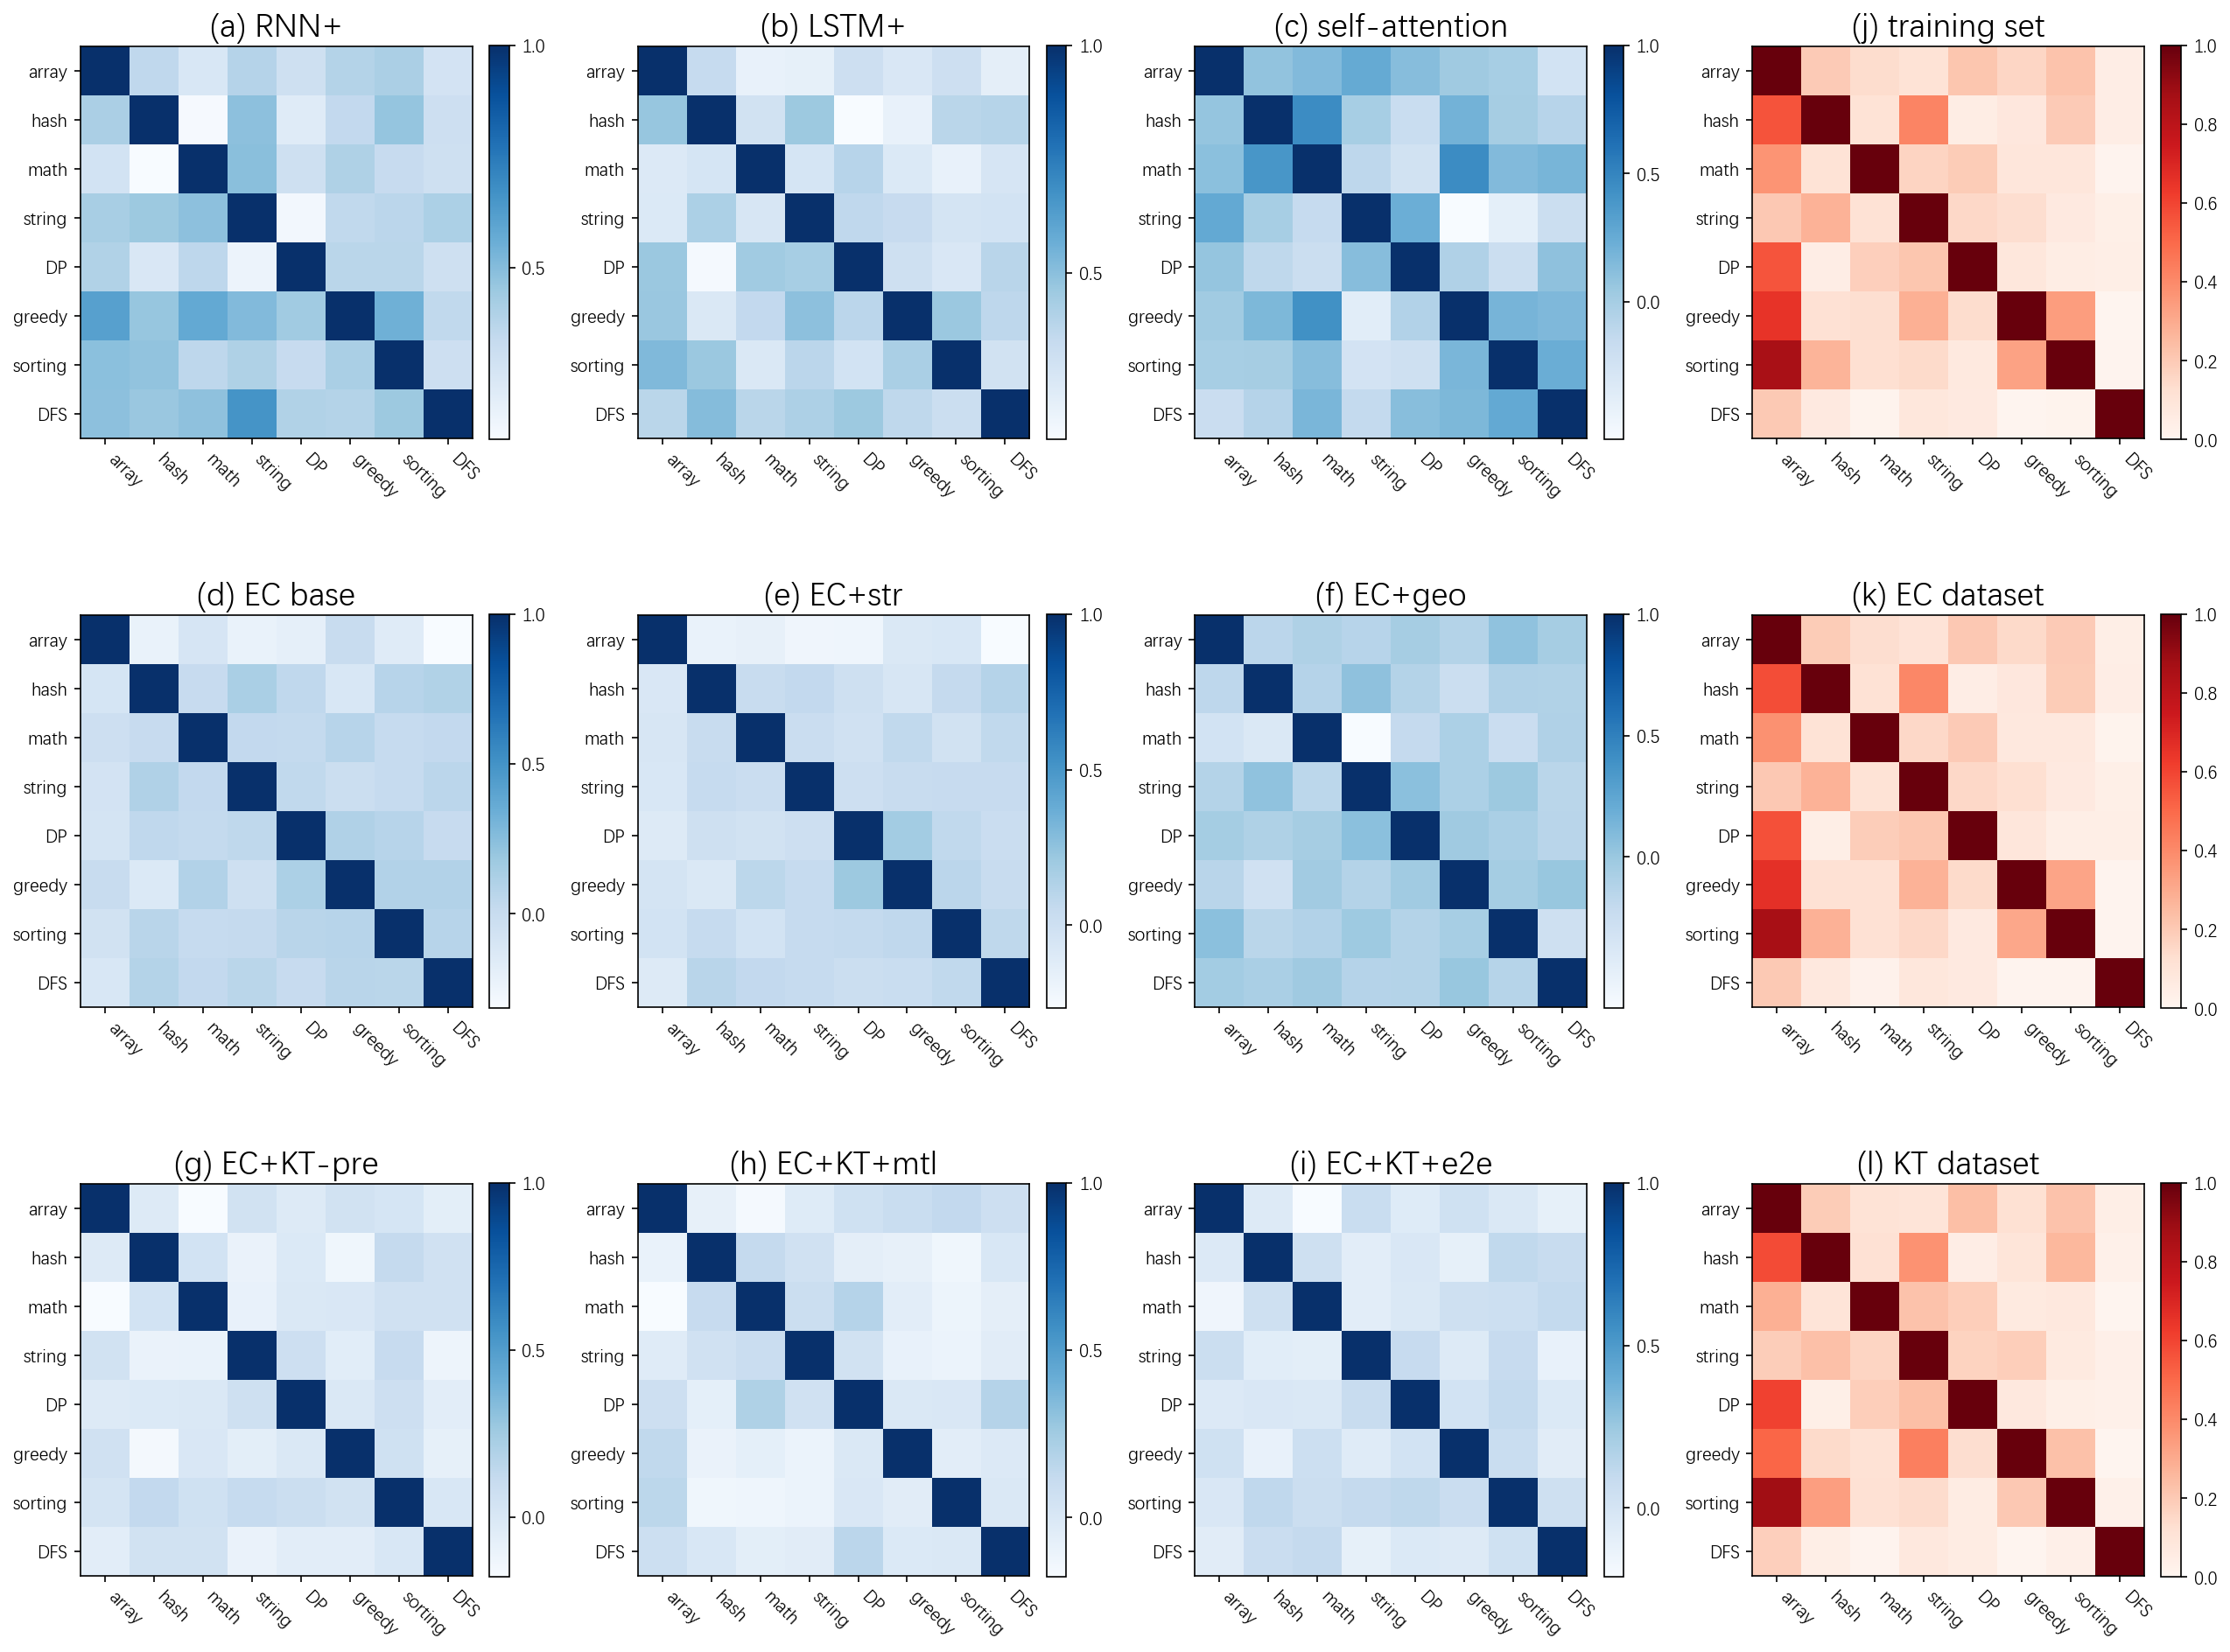

In [12]:
fig = plt.figure(num=1, figsize=(20, 15), dpi=150, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ttl_list = ['(a) RNN+', '(b) LSTM+', '(c) self-attention', '(d) EC base', '(e) EC+str', '(f) EC+geo', 
            '(g) EC+KT-pre', '(h) EC+KT+mtl', '(i) EC+KT+e2e', '(j) training set', '(k) EC dataset', '(l) KT dataset',]

for i in range(9):
    idx = 1 + i % 3 + 4 * (i // 3)
    axe = fig.add_subplot(3, 4, idx)
    cos_mat = cos_reduction(mat_list[i])
    img = axe.imshow(cos_mat, interpolation='nearest', cmap=plt.cm.Blues)
    axe.set_xticks(range(len(lbl_list)))
    axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
    axe.set_yticks(range(len(lbl_list)))
    axe.set_yticklabels(lbl_list)
    axe.set_title(ttl_list[i], fontsize=18)
    plt.colorbar(img, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

axe = fig.add_subplot(3, 4, 4)
coo_mat = coo_reduction(train_geo)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[-3], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(3, 4, 8)
coo_mat = coo_reduction(total_geo)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[-2], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(3, 4, 12)
coo_mat = coo_reduction(total_geo, exe_dct)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[-1], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

plt.savefig('./results/cmp_ec/cmp_ec_mat_con.jpg')
plt.show()